In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
from prophet import Prophet

# Import Datasets

Data from the following places will be used. I choose a to use only data from 2021-2023

- CPI (https://stats.oecd.org/index.aspx?DataSetCode=PRICES_CPI#)
- dollar (https://ru.investing.com/currencies/usd-zar-historical-data)
- petrol prices (https://www.energy.gov.za/files/esources/petroleum/petroleum_arch.html)

In [35]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [36]:
cpi = pd.read_csv(path + '/data/PRICES_CPI_11062023152547285.csv')
dollar = pd.read_csv(path + '/data/DEXSFUS.csv', delimiter=';')
fuel_2021 = pd.read_csv(path + '/data/Basic-Fuel-Price2021.csv', delimiter=';')
fuel_2022 = pd.read_csv(path + '/data/Basic-Fuel-Price2022.csv', delimiter=';')
fuel_2023 = pd.read_csv(path + '/data/Basic-Fuel-Price2023.csv', delimiter=';')

fuel_2021['year'] = '2021'
fuel_2022['year'] = '2022'
fuel_2023['year'] = '2023'

fuel = pd.concat([fuel_2022[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2021[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2023[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']]])

# EDA
## View CPI

In [37]:
cpi_columns = {'Food and non-Alcoholic beverages' : 'Food', 
               'All items': 'CPI',
               'Alcoholic beverages, tobacco and narcotics': 'Alcohol',
               'Clothing and footwear': 'Clothes',
               'Housing, water, electricity, gas and other fuels': 'Household', 
               'Transport': 'Transport',
               'Recreation and culture': 'Recreation', 
               'Health': 'Health',
               'Furnishings, household equipment and routine household maintenance': 'Furnishings',
               'Communication': 'Communication',
               'Education': 'Education',
               'Restaurants and hotels': 'Restaurants', 
               'Miscellaneous goods and services': 'Other services'}

In [38]:
# Select only where measure in Index
cpi = cpi[cpi['Measure'] == 'National Index']

In [39]:
# get categories
cpi['cpi_cat'] = cpi['Subject'].apply(lambda x: x.split('- ')[-1])
cpi = cpi[cpi['cpi_cat'].isin(cpi_columns)][['Time', 'cpi_cat', 'Value']]

In [40]:
# change month to datetime format
cpi['Date'] = pd.to_datetime(cpi['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_82352/3347956333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [41]:
# map categories to shorter names
cpi = cpi.replace(cpi_columns)

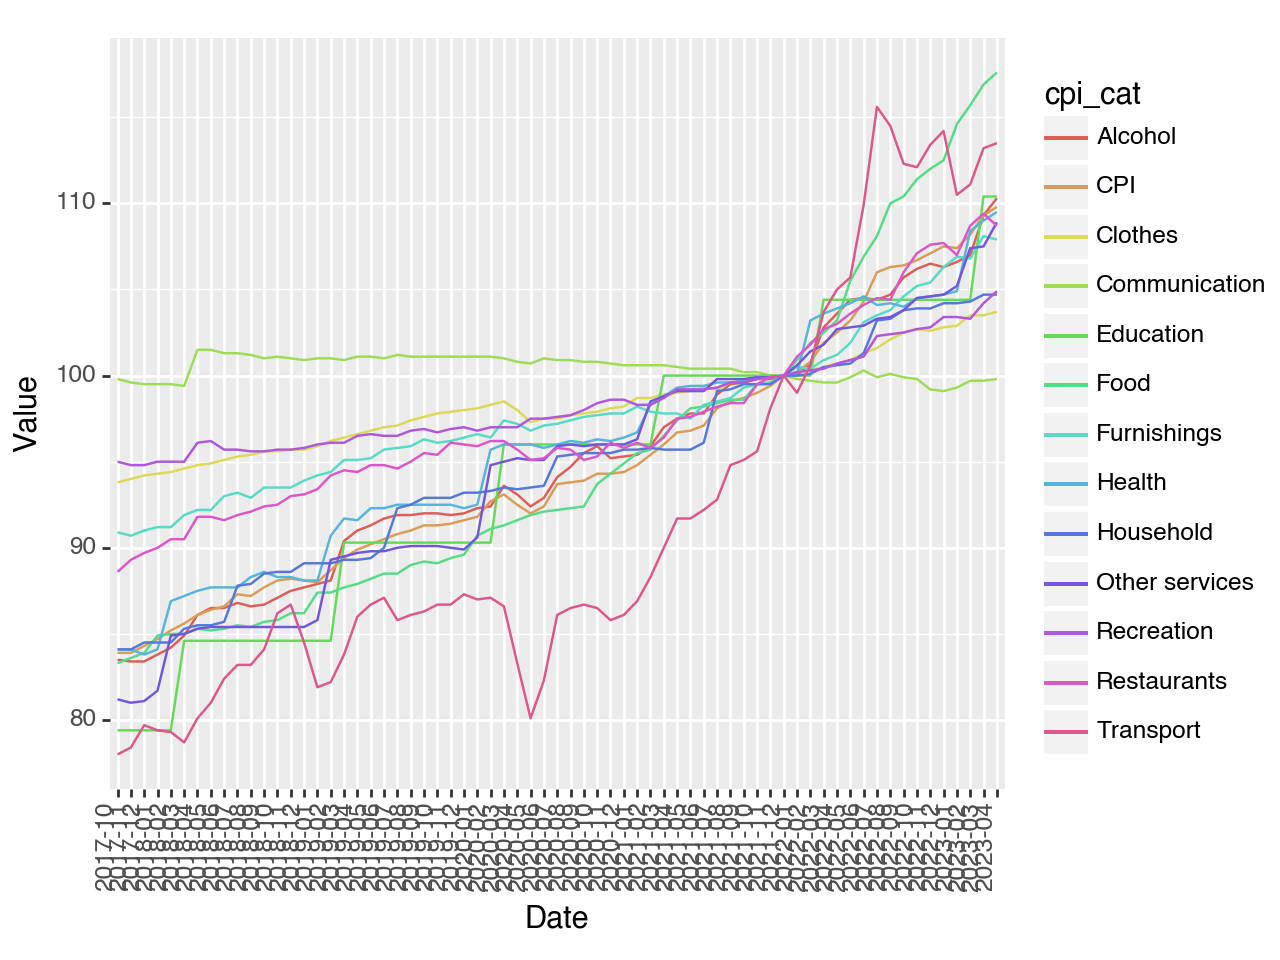

<Figure Size: (640 x 480)>

In [42]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

In [43]:
cpi = cpi.loc[(cpi['Date'] >= '2021-12-31')]

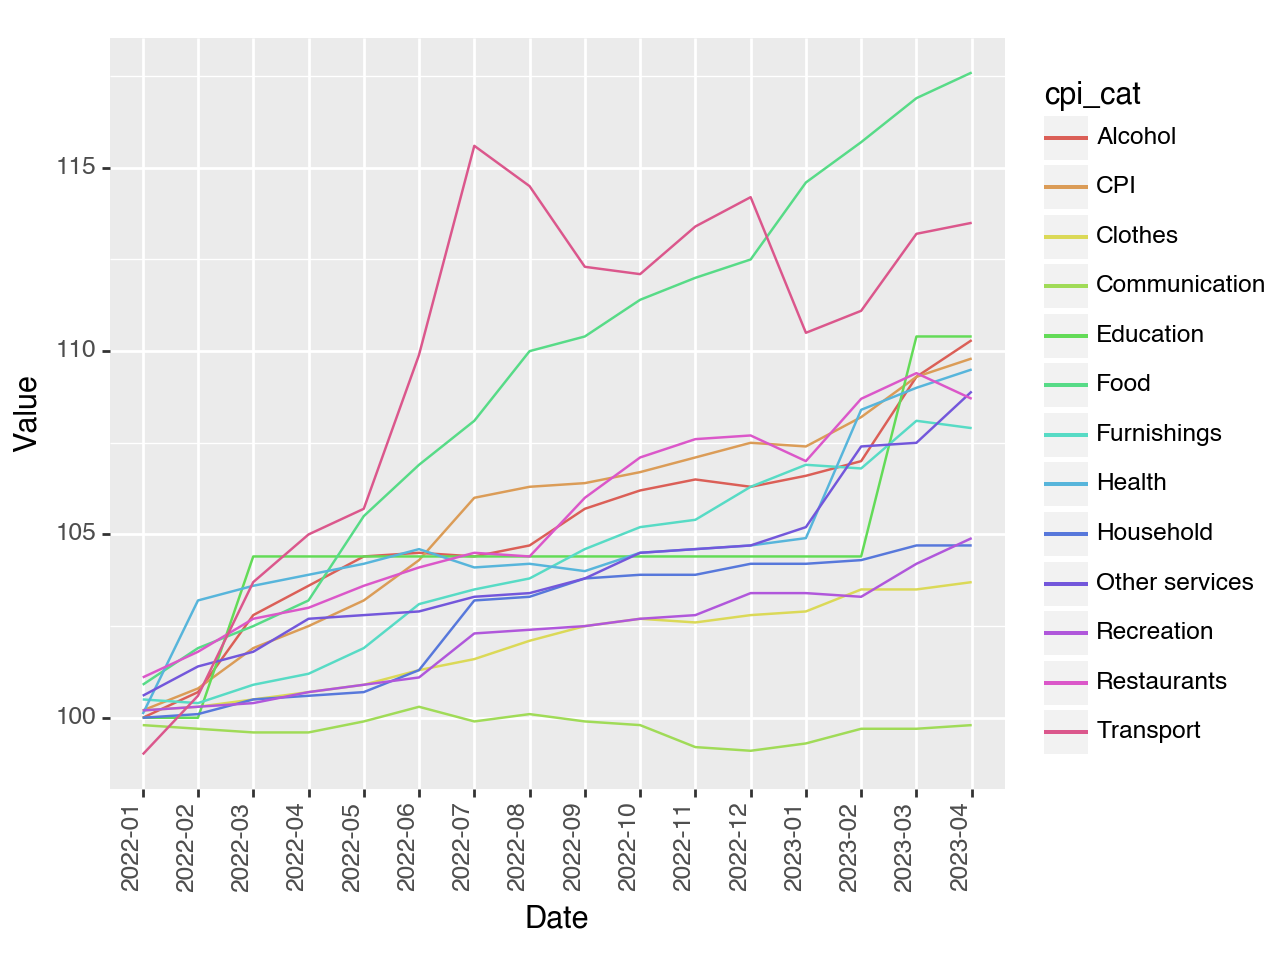

<Figure Size: (640 x 480)>

In [44]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

# Add Fuel and Dollar

In [45]:
fuel['Time'] = fuel['RSAc/litre'] + '-' + fuel['year']

# # change month to datetime format
fuel['Date'] = pd.to_datetime(fuel['Time']).dt.strftime('%Y-%m')
fuel.columns = ['Petrol', 'year', 'month', 'Time', 'Date']
dollar['Date'] = pd.to_datetime(dollar['DATE'], format='%d.%m.%Y').dt.strftime('%Y-%m')
dollar['Dollar'] = dollar['PRICE'].apply(lambda x: float(x.replace(',', '.')))
dollar.columns = ['Time', 'PRICE', 'Date', 'Dollar']
dollar = dollar[['Date', 'Dollar']].groupby(['Date'])['Dollar'].agg('mean').to_frame().reset_index()

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_82352/3799672639.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [46]:
# correct some incorrect data in fuel prices
fuel['Petrol'] = [float(str(x).replace(' ', '')) for x in fuel['Petrol']]

In [47]:
df_all = pd.merge(cpi, dollar[['Dollar', 'Date']], on='Date', how='left')
df_all = pd.merge(df_all, fuel[['Petrol', 'Date']], on='Date', how='left')

# Model

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [49]:
df_prophet_pred = []

for cat in cpi_columns.values():
    data = df_all[df_all['cpi_cat']==cat]['Value'].values
    model = ExponentialSmoothing(data, trend='add')
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(data), len(data))
    df_prophet_pred.append({'Time':'May-2023', 'cpi_cat':cat, 'Value':yhat[0]})

In [50]:
df_may = pd.concat([df_all[['Time', 'cpi_cat', 'Value']], pd.DataFrame(df_prophet_pred)])
df_may['Date'] = pd.to_datetime(df_may['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_82352/3911873248.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


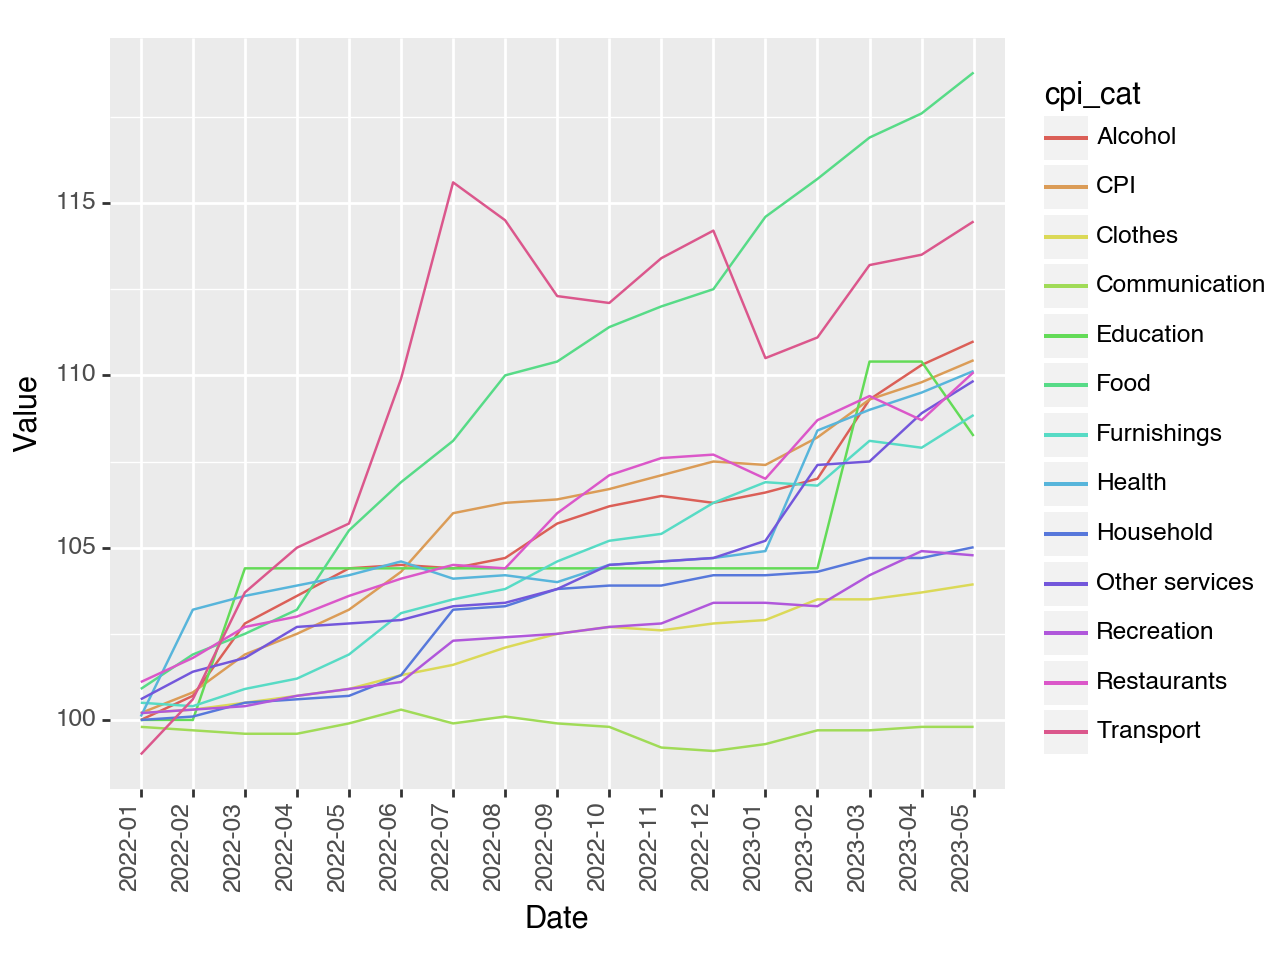

<Figure Size: (640 x 480)>

In [51]:
(ggplot(df_may) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

# Predict for June using the May prediction

In [61]:
df_prophet_pred = []

for cat in cpi_columns.values():
    data = df_may[df_may['cpi_cat']==cat]['Value'].values
    model = ExponentialSmoothing(data, trend='add', damped_trend=True)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(data), len(data))
    df_prophet_pred.append({'Time':'June-2023', 'cpi_cat':cat, 'Value':yhat[0]})

In [62]:
df_june = pd.DataFrame(df_prophet_pred)

# Get submission

In [ ]:
df_sub = df_june[['cpi_cat', 'Value']]
df_sub.columns = ['ID', 'Value']

In [55]:
month = 'June'

In [56]:
pred_map = {'CPI': f'{month}_headline CPI',
'Alcohol': f'{month}_alcoholic beverages and tobacco',
'Clothes': f'{month}_clothing and footwear',
'Communication': f'{month}_communication',
'Education': f'{month}_education',
'Food': f'{month}_food and non-alcoholic beverages',
'Health': f'{month}_health',
'Furnishings': f'{month}_household contents and services',
'Household': f'{month}_housing and utilities',
'Other services': f'{month}_miscellaneous goods and services',
'Recreation': f'{month}_recreation and culture',
'Restaurants': f'{month}_restaurants and hotels',
'Transport': f'{month}_transport'}

In [57]:
df_sub = df_sub.replace(pred_map)

In [58]:
df_sub.to_csv(path + '/submissions/v9_holtwinters.csv', index=False)